In [1]:
import numpy as np 
import pandas as pd
import os
import gc
import re

# feature libraries
from scipy.sparse import hstack, csr_matrix
from sklearn import preprocessing
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from rfpimp import plot_corr_heatmap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# timer function
import time
from contextlib import contextmanager

@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print(f'[{name}] done in {time.time() - t0:.0f} s')

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
start_time = time.time()


In [2]:
data_dir = '../input/kaggle_data'
feat_dir = '../input/features'

In [49]:
num_cols = []
cat_cols = []

with timer("load data:"):
    usecols = ['item_id']
    train = pd.read_csv(f'{data_dir}/train.csv', index_col="item_id", usecols=usecols+['deal_probability'])
    test = pd.read_csv(f'{data_dir}/test.csv', index_col="item_id", usecols=usecols)

    train_split = len(train)
    y = train['deal_probability'].copy()
    train.drop("deal_probability",axis=1, inplace=True)
    
    gc.collect()
    
with timer("Loading Label Encoded Features:"):
    train_le = pd.read_csv(f'{feat_dir}/train_le.csv', index_col="item_id")
    test_le = pd.read_csv(f'{feat_dir}/test_le.csv', index_col="item_id")
    
    train = train.merge(train_le, how='left', left_index=True, right_index=True)
    test = test.merge(test_le, how='left', left_index=True, right_index=True)
    
    cat_cols += ['region','city','parent_category_name','category_name','user_type','param_1','param_2','param_3']
    
    del train_le, test_le
    gc.collect()
    
with timer("Loading Numeric Encoded Features:"):
    train_numeric = pd.read_csv(f'{feat_dir}/train_numeric.csv', index_col="item_id")
    test_numeric = pd.read_csv(f'{feat_dir}/test_numeric.csv', index_col="item_id")
    
    train = train.merge(train_numeric, how='left', left_index=True, right_index=True)
    test = test.merge(test_numeric, how='left', left_index=True, right_index=True)
    
    cat_cols += ['price_missing','image_top_1_missing']
    num_cols += ['item_seq_number','image_top_1','price']

    del train_numeric, test_numeric
    gc.collect()
    
with timer("Loading NIMA Features:"):
    train_nima = pd.read_csv(f'{feat_dir}/train_nima.csv', index_col="item_id")
    test_nima = pd.read_csv(f'{feat_dir}/test_nima.csv', index_col="item_id")
    
    train = train.merge(train_nima, how='left', left_index=True, right_index=True)
    test = test.merge(test_nima, how='left', left_index=True, right_index=True)
    
    num_cols += ["mobile_mean", "mobile_std","inception_mean", "inception_std", "nasnet_mean", "nasnet_std"]

    del train_nima, test_nima
    gc.collect() 
        
# train.reset_index(inplace=True, drop=True)
# test.reset_index(inplace=True, drop=True)

[load data:] done in 5 s
[Loading Label Encoded Features:] done in 3 s
[Loading Numeric Encoded Features:] done in 3 s
[Loading NIMA Features:] done in 4 s


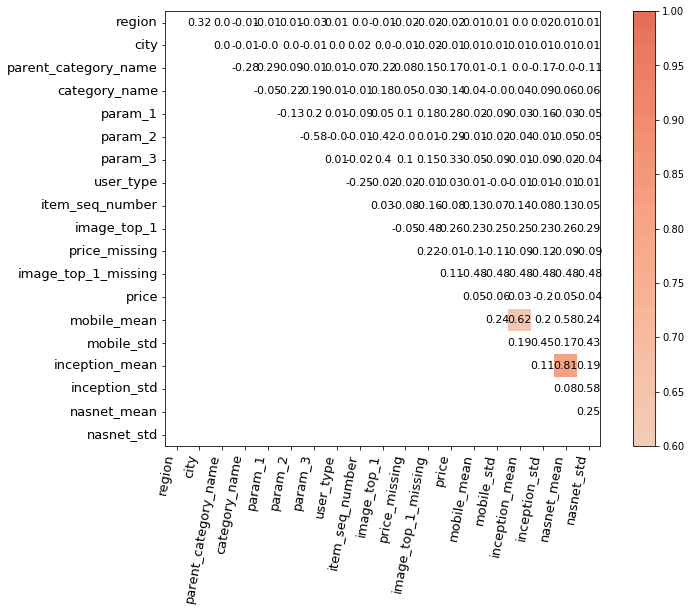

In [5]:
plot_corr_heatmap(test, figsize=(12,8), label_fontsize=13, value_fontsize=11)

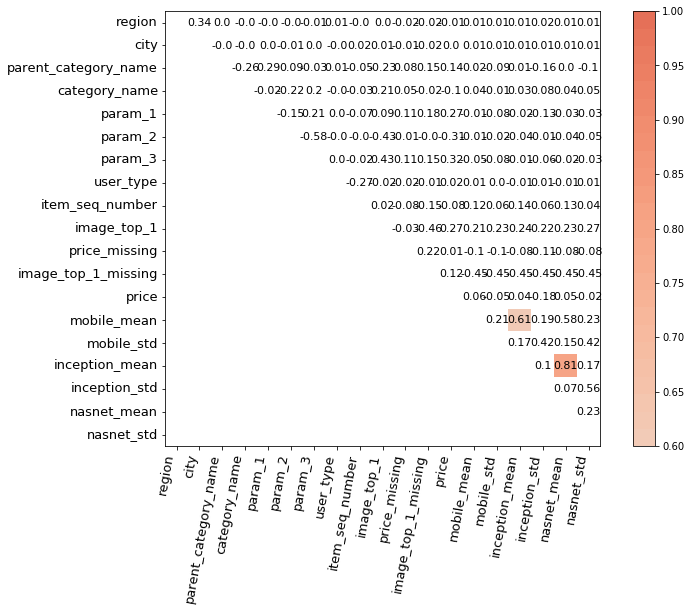

In [6]:
plot_corr_heatmap(train, figsize=(12,8), label_fontsize=13, value_fontsize=11)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.6, random_state=0)

mdl = RandomForestRegressor(n_jobs=-1, random_state=0)
mdl.fit(X_train, y_train)

for feature in sorted(zip(train.columns, mdl.feature_importances_), key=lambda x: x[1] * -1):
    print(feature)
    
del X_train, X_test, y_train, y_test 
gc.collect()


In [50]:
with timer("Create potential interactions:"):
    
    important_cols = ['image_top_1','price', 'item_seq_number', 'mobile_mean', 'mobile_std', 'inception_mean',
                      'inception_std', 'nasnet_mean', 'nasnet_std']
    
    def interaction_features(train, test, fea1, fea2, prefix):
        train['inter_{}_x_{}'.format(fea1, fea2)] = train[fea1] * train[fea2]
        train['inter_{}_d_{}'.format(fea1, fea2)] = train[fea1] / train[fea2]

        test['inter_{}_x_{}'.format(fea1, fea2)] = test[fea1] * test[fea2]
        test['inter_{}_d_{}'.format(fea1, fea2)] = test[fea1] / test[fea2]

        return train, test

    for e, (x, target) in enumerate(combinations(important_cols, 2)):
        train, test = interaction_features(train, test, x, target, e)
        
    inter_cols = [x for x in list(train) if 'inter' in x]

[Create potential interactions:] done in 1 s


In [103]:
# inter_cols
train_interact = train[[x for x in list(train) if ('inter' in x)]].copy()
test_interact = test[[x for x in list(test) if ('inter' in x)]].copy()

In [90]:
corr_matrix = train_interact.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

train_interact.drop(to_drop, axis=1,inplace=True)
test_interact.drop(to_drop, axis=1,inplace=True)

In [92]:
X_train, X_test, y_train, y_test = train_test_split(train_interact, y, test_size=0.6, random_state=0)

mdl = RandomForestRegressor(n_jobs=-1, random_state=0)
mdl.fit(X_train, y_train)
for feature in zip(train_interact.columns, mdl.feature_importances_):
    print(feature)
    
del X_train, X_test, y_train, y_test 
gc.collect()

('inter_image_top_1_x_price', 0.10730118658826857)
('inter_image_top_1_d_price', 0.05147574899078129)
('inter_image_top_1_x_item_seq_number', 0.03242697858632617)
('inter_image_top_1_d_item_seq_number', 0.03127133922563503)
('inter_image_top_1_x_mobile_mean', 0.03332844529076208)
('inter_image_top_1_d_mobile_mean', 0.01616334934662276)
('inter_image_top_1_d_mobile_std', 0.017423987362612185)
('inter_image_top_1_d_inception_mean', 0.015002888720209068)
('inter_image_top_1_d_inception_std', 0.016877404758580298)
('inter_image_top_1_d_nasnet_mean', 0.02887100200888163)
('inter_image_top_1_d_nasnet_std', 0.017456921297890365)
('inter_price_x_item_seq_number', 0.038247965762503375)
('inter_price_d_item_seq_number', 0.04155801338725111)
('inter_price_d_mobile_mean', 0.01429212534393579)
('inter_price_d_mobile_std', 0.017366882696213698)
('inter_price_d_inception_mean', 0.014009227691556733)
('inter_price_d_inception_std', 0.014826088999487213)
('inter_price_d_nasnet_std', 0.01715017402309828

1045

In [105]:
# values = pd.DataFrame(sorted(zip(train_interact.columns, mdl.feature_importances_), key=lambda x: x[1] * -1))
keep_cols = values[0].head(10).values
train_interact = train_interact[[x for x in list(train_interact) if x in keep_cols]]
test_interact = test_interact[[x for x in list(test_interact) if x in keep_cols]]

In [107]:
train_interact.head()

,inter_image_top_1_x_price,inter_image_top_1_d_price,inter_image_top_1_x_item_seq_number,inter_image_top_1_d_item_seq_number,inter_image_top_1_x_mobile_mean,inter_price_x_item_seq_number,inter_price_d_item_seq_number,inter_item_seq_number_x_nasnet_mean,inter_item_seq_number_d_nasnet_std,inter_mobile_mean_d_nasnet_mean
item_id,,,,,,,,,,
b912c3c6a6ad,0.000787,29.687114,0.020831,1.120907,-0.057526,0.000702,0.037757,0.009723,-2.275159,-5.278350
2dac0150717d,0.002410,92.604356,0.062960,3.544123,-0.179526,0.000680,0.038272,-0.032040,3.951830,1.580975
ba83aefab5dc,-0.009628,-372.608017,-0.255834,-14.022450,1.027640,0.000687,0.037633,-0.127752,-0.336442,0.573652
02996f1dd2ea,0.001878,71.785743,0.031408,4.293082,-0.161881,0.000438,0.059804,-0.041583,-0.266215,0.906789
7c90be56d2ab,-0.004964,-251.498294,-0.152126,-8.207211,0.057867,0.000605,0.032633,-0.059462,-0.488203,0.118576


In [108]:
train_interact.to_csv(f'{feat_dir}/train_interact.csv', index=True, header=True)
test_interact.to_csv(f'{feat_dir}/test_interact.csv', index=True, header=True)